<a href="https://colab.research.google.com/github/sowmyamanojna/CS6024-Algorithmic-Approaches-to-Computational-Biology-Project/blob/master/codes/vae_dae/vae_retrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

%tensorflow_version 1.x
import tensorflow as tf
from keras import backend as K
from keras import optimizers, metrics
from keras.callbacks import Callback
from keras.layers import Input, Dense, Lambda, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.regularizers import l1

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# From tybalt.utils.vae_utils
def approx_keras_binary_cross_entropy(x, z, p, epsilon=1e-07):
    """
    Function to approximate Keras `binary_crossentropy()`
    https://github.com/keras-team/keras/blob/e6c3f77b0b10b0d76778109a40d6d3282f1cadd0/keras/losses.py#L76
    Which is a wrapper for TensorFlow `sigmoid_cross_entropy_with_logits()`
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
    An important step is to clip values of reconstruction
    https://github.com/keras-team/keras/blob/a3d160b9467c99cbb27f9aa0382c759f45c8ee66/keras/backend/tensorflow_backend.py#L3071
    Arguments:
    x - Reconstructed input RNAseq data
    z - Input RNAseq data
    p - number of features
    epsilon - the clipping value to stabilize results (same Keras default)
    """
    # Ensure numpy arrays
    x = np.array(x)
    z = np.array(z)

    # Add clip to value
    x[x < epsilon] = epsilon
    x[x > (1 - epsilon)] = (1 - epsilon)

    # Perform logit
    x = np.log(x / (1 - x))

    # Return approximate binary cross entropy
    return np.mean(p * np.mean(- x * z + np.log(1 + np.exp(x)), axis=-1))


class VariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    """
    def __init__(self, var_layer, mean_layer, original_dim, beta, loss,
                 **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        self.var_layer = var_layer
        self.mean_layer = mean_layer
        self.original_dim = original_dim
        self.beta = beta
        self.loss = loss
        super(VariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        if self.loss == 'binary_crossentropy':
            recon_loss = self.original_dim * \
                         metrics.binary_crossentropy(x_input, x_decoded)
        elif self.loss == 'mse':
            recon_loss = self.original_dim * \
                         metrics.mean_squared_error(x_input, x_decoded)

        kl_loss = - 0.5 * K.sum(1 + self.var_layer -
                                K.square(self.mean_layer) -
                                K.exp(self.var_layer), axis=-1)

        return K.mean(recon_loss + (K.get_value(self.beta) * kl_loss))

    def call(self, inputs):
        x, x_decoded = inputs
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x


class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        """
        Behavior on each epoch
        """
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)


class LossCallback(Callback):
    def __init__(self, training_data, original_dim, encoder_cbk, decoder_cbk):
        self.training_data = training_data
        self.original_dim = original_dim
        self.encoder_cbk = encoder_cbk
        self.decoder_cbk = decoder_cbk

    def on_train_begin(self, logs={}):
        self.xent_loss = []
        self.kl_loss = []

    def on_epoch_end(self, epoch, logs={}):
        recon = self.decoder_cbk.predict(
            self.encoder_cbk.predict(self.training_data))
        xent_loss = approx_keras_binary_cross_entropy(x=recon,
                                                      z=self.training_data,
                                                      p=self.original_dim)
        full_loss = logs.get('loss')
        self.xent_loss.append(xent_loss)
        self.kl_loss.append(full_loss - xent_loss)
        return

In [4]:
# From tybalt.utils.base
from keras.utils import plot_model


class BaseModel():
    def __init__(self):
        pass

    def get_summary(self):
        self.full_model.summary()

    def visualize_architecture(self, output_file):
        # Visualize the connections of the custom VAE model
        plot_model(self.full_model, to_file=output_file)

    def visualize_training(self, output_file=None):
        # Visualize training performance
        history_df = pd.DataFrame(self.hist.history)
        ax = history_df.plot()
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        fig = ax.get_figure()
        if output_file:
            fig.savefig(output_file)
        else:
            fig.show()

    def get_weights(self, decoder=True):
        # Extract weight matrices from encoder or decoder
        weights = []
        if decoder:
            for layer in self.decoder.layers:
                weights.append(layer.get_weights())
        else:
            for layer in self.encoder.layers:
                # Encoder weights must be transposed
                encoder_weights = layer.get_weights()
                encoder_weights = [np.transpose(x) for x in encoder_weights]
                weights.append(encoder_weights)
        return weights

    def save_models(self, encoder_file, decoder_file):
        self.encoder.save(encoder_file)
        self.decoder.save(decoder_file)


class VAE(BaseModel):
    def __init__(self):
        BaseModel.__init__(self)

    def _sampling(self, args):
        """
        Function for reparameterization trick to make model differentiable
        """
        # Function with args required for Keras Lambda function
        z_mean, z_log_var = args

        # Draw epsilon of the same shape from a standard normal distribution
        epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                                  stddev=self.epsilon_std)

        # The latent vector is non-deterministic and differentiable
        # in respect to z_mean and z_log_var
        z = z_mean + K.exp(z_log_var / 2) * epsilon
        return z

    def initialize_model(self):
        """
        Helper function to run that builds and compiles Keras layers
        """
        self._build_encoder_layer()
        self._build_decoder_layer()
        self._compile_vae()
        self._connect_layers()

    def compress(self, df):
        # Encode rnaseq into the hidden/latent representation - and save output
        # a cVAE expects a list of [rnaseq_df, y_df]
        encoded_df = self.encoder.predict_on_batch(df)

        if self.model_name == 'cTybalt':
            named_index = df[0].index
        else:
            named_index = df.index

        encoded_df = pd.DataFrame(encoded_df,
                                  columns=range(1, self.latent_dim + 1),
                                  index=named_index)
        return encoded_df

In [5]:
class Tybalt(VAE):
    """
    Training and evaluation of a tybalt model
    Usage: from tybalt.models import Tybalt
    """
    def __init__(self, original_dim, latent_dim, batch_size=50, epochs=50,
                 learning_rate=0.0005, kappa=1, epsilon_std=1.0,
                 beta=K.variable(0), loss='binary_crossentropy',
                 verbose=True):
        VAE.__init__(self)
        self.model_name = 'Tybalt'
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kappa = kappa
        self.epsilon_std = epsilon_std
        self.beta = beta
        self.loss = loss
        self.verbose = verbose

    def _build_encoder_layer(self):
        """
        Function to build the encoder layer connections
        """
        # Input place holder for RNAseq data with specific input size
        self.rnaseq_input = Input(shape=(self.original_dim, ))

        # Input layer is compressed into a mean and log variance vector of
        # size `latent_dim`. Each layer is initialized with glorot uniform
        # weights and each step (dense connections, batch norm, and relu
        # activation) are funneled separately.
        # Each vector are connected to the rnaseq input tensor

        # input layer to latent mean layer
        z_mean = Dense(self.latent_dim,
                       kernel_initializer='glorot_uniform')(self.rnaseq_input)
        z_mean_batchnorm = BatchNormalization()(z_mean)
        self.z_mean_encoded = Activation('relu')(z_mean_batchnorm)

        # input layer to latent standard deviation layer
        z_var = Dense(self.latent_dim,
                      kernel_initializer='glorot_uniform')(self.rnaseq_input)
        z_var_batchnorm = BatchNormalization()(z_var)
        self.z_var_encoded = Activation('relu')(z_var_batchnorm)

        # return the encoded and randomly sampled z vector
        # Takes two keras layers as input to the custom sampling function layer
        self.z = Lambda(self._sampling,
                        output_shape=(self.latent_dim, ))([self.z_mean_encoded,
                                                           self.z_var_encoded])

    def _build_decoder_layer(self):
        """
        Function to build the decoder layer connections
        """
        # The decoding layer is much simpler with a single layer glorot uniform
        # initialized and sigmoid activation
        self.decoder_model = Sequential()
        self.decoder_model.add(Dense(self.original_dim, activation='sigmoid',
                                     input_dim=self.latent_dim))
        self.rnaseq_reconstruct = self.decoder_model(self.z)

    def _compile_vae(self):
        """
        Creates the vae layer and compiles all layer connections
        """
        adam = optimizers.Adam(lr=self.learning_rate)
        vae_layer = VariationalLayer(var_layer=self.z_var_encoded,
                                     mean_layer=self.z_mean_encoded,
                                     original_dim=self.original_dim,
                                     beta=self.beta, loss=self.loss)(
                                [self.rnaseq_input, self.rnaseq_reconstruct])
        self.full_model = Model(self.rnaseq_input, vae_layer)
        self.full_model.compile(optimizer=adam, loss=None,
                                loss_weights=[self.beta])

    def _connect_layers(self):
        """
        Make connections between layers to build separate encoder and decoder
        """
        self.encoder = Model(self.rnaseq_input, self.z_mean_encoded)

        decoder_input = Input(shape=(self.latent_dim, ))
        _x_decoded_mean = self.decoder_model(decoder_input)
        self.decoder = Model(decoder_input, _x_decoded_mean)

    def train_vae(self, train_df, test_df, separate_loss=False):
        """
        Method to train model.
        `separate_loss` instantiates a custom Keras callback that tracks the
        separate contribution of reconstruction and KL divergence loss. Because
        VAEs try to minimize both, it may be informative to track each across
        training separately. The callback processes the training data through
        the current encoder and decoder and therefore requires additional time
        - which is why this is not done by default.
        """
        cbks = [WarmUpCallback(self.beta, self.kappa)]
        if separate_loss:
            tybalt_loss_cbk = LossCallback(training_data=np.array(train_df),
                                           encoder_cbk=self.encoder,
                                           decoder_cbk=self.decoder,
                                           original_dim=self.original_dim)
            cbks += [tybalt_loss_cbk]

        self.hist = self.full_model.fit(np.array(train_df),
                                        shuffle=True,
                                        epochs=self.epochs,
                                        batch_size=self.batch_size,
                                        verbose=self.verbose,
                                        validation_data=(np.array(test_df),
                                                         None),
                                        callbacks=cbks)
        self.history_df = pd.DataFrame(self.hist.history)

        if separate_loss:
            self.history_df = self.history_df.assign(
                                recon=tybalt_loss_cbk.xent_loss)
            self.history_df = self.history_df.assign(
                                kl=tybalt_loss_cbk.kl_loss)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
pcos_df = pd.read_csv('/content/drive/MyDrive/aacb_project/datasets/common_normalized.csv', index_col=0)
pcos_df = pcos_df.drop(['sample_id'], axis=1)

# Split 10% test set randomly
test_set_percent = 0.1

pcos_test_df = pcos_df.sample(frac=test_set_percent)
pcos_train_df = pcos_df.drop(pcos_test_df.index)

display(pcos_train_df.head(2))
display(pcos_test_df.head(2))

,27,36,59,87,94,105,153,159,164,226,288,290,311,330,334,335,345,355,359,377,382,389,392,394,405,408,420,430,443,463,476,487,488,515,533,552,567,572,582,586,...,92558,92815,92822,93164,93487,93974,6248_84301,8693_100528030,100506581,112399,112479,374655,375035,375057,113251,114088,114791,114882,116228,116285,116985,116986,51463_653519,118491,118987,120227,645644,100129482,100529257_55333,253512,122704,253959,254359,254531,100132341,387893,388336,259266,261726,PCOS
0,0.693258,0.125461,0.336077,0.044463,0.267819,0.467742,0.490196,0.008907,0.370576,0.953515,0.0000,0.060236,0.230814,0.078014,0.119300,1.0,1.000000,0.000000,0.712054,0.648867,0.535433,0.593551,0.651320,0.000000,0.000000,1.000000,0.132791,1.0,0.000000,0.263318,0.725872,0.701149,0.395953,0.302829,0.839330,0.349876,0.835372,0.502399,0.800414,0.000000,...,1.000000,0.609797,0.146067,0.064516,0.915703,0.768041,0.925659,0.000000,0.855740,0.130112,0.000000,1.000000,0.086751,0.288095,0.000000,0.560748,0.965517,0.000000,0.121212,0.000000,1.000000,0.261745,0.209231,0.061603,0.295745,0.489703,0.481948,0.113924,0.100254,0.000000,0.369072,0.000000,0.39619,1.000000,0.412466,0.000000,0.312354,0.198387,0.120213,1
1,0.214607,0.487085,0.589704,0.104294,0.000000,0.106452,0.000000,0.631829,0.476058,1.000000,0.0409,0.038093,0.799387,0.131206,0.118719,0.0,0.025316,0.216724,0.023437,0.286346,0.619005,0.946925,0.854954,0.337931,0.352278,0.149398,0.636856,0.0,0.184211,0.238965,0.808785,0.609195,0.561854,0.916302,0.265155,0.285360,0.808202,0.291843,0.515512,0.084831,...,0.677019,0.142455,0.070225,0.129032,0.512184,0.694845,0.000000,0.536028,0.937385,0.000000,0.809129,0.158155,0.586751,0.424603,0.644419,1.000000,0.000000,0.949077,0.994318,0.085938,0.427987,0.049664,0.763077,0.000000,1.000000,0.080092,0.000000,0.082278,0.407360,0.418699,0.437113,0.367855,0.56419,0.497418,0.325390,0.356499,0.173660,0.430645,1.000000,1


,27,36,59,87,94,105,153,159,164,226,288,290,311,330,334,335,345,355,359,377,382,389,392,394,405,408,420,430,443,463,476,487,488,515,533,552,567,572,582,586,...,92558,92815,92822,93164,93487,93974,6248_84301,8693_100528030,100506581,112399,112479,374655,375035,375057,113251,114088,114791,114882,116228,116285,116985,116986,51463_653519,118491,118987,120227,645644,100129482,100529257_55333,253512,122704,253959,254359,254531,100132341,387893,388336,259266,261726,PCOS
23,0.129505,0.181005,0.924609,0.148352,0.667476,0.308571,0.399707,0.072805,0.283274,0.166885,0.092105,0.233102,0.950314,0.087576,0.165382,0.101295,0.850775,0.391562,0.709706,0.504050,0.032042,0.0,1.000000,0.201385,0.237093,0.532035,0.320378,0.174917,0.537500,0.527110,0.301370,0.118644,0.394805,0.304545,0.886182,0.691932,0.732815,0.247788,0.526245,0.343293,...,0.049383,0.147849,0.537037,0.190012,0.000000,0.535132,0.519948,0.000000,0.080819,0.066770,0.055517,0.548400,0.675879,0.822034,0.850120,0.210145,0.366419,1.00000,0.363089,0.227196,0.156654,0.021053,0.559778,0.000000,0.689993,1.000000,0.788043,0.178251,0.496886,0.900915,0.715411,0.473233,0.188396,0.245631,0.196678,0.648442,0.184979,0.385505,0.644742,0
109,0.239703,0.649477,0.078745,0.000000,0.266449,0.146422,0.431584,0.503799,0.520344,0.364528,0.485421,0.039343,1.000000,0.253401,0.356205,0.028227,0.092454,0.000000,0.126762,0.222732,0.363461,0.0,0.150554,0.572913,0.207787,0.080381,0.646698,0.186215,0.823966,0.269807,0.660864,0.426235,0.069061,0.588288,0.249296,0.386684,0.219280,0.000000,0.917404,0.000000,...,0.000000,0.272666,0.824473,0.250663,0.764054,0.260222,0.250448,0.476643,0.015934,0.282625,0.342973,0.180708,0.435645,0.233691,0.417996,0.158665,0.343397,0.55412,0.640270,0.462755,0.439467,0.057574,0.888190,0.531518,0.344512,0.179327,0.000000,0.575808,0.457257,0.239723,0.203369,0.214708,0.173022,0.689886,0.000000,0.000000,0.071049,0.281503,0.916737,-1


In [8]:
original_dim = pcos_df.shape[1]
latent_dim = 2

In [15]:
vae = Tybalt(original_dim, latent_dim, batch_size=50, epochs=2000,
                 learning_rate=0.005, kappa=1, epsilon_std=1.0,
                 beta=K.variable(0), loss='binary_crossentropy',
                 verbose=True)
vae._build_encoder_layer()
vae._build_decoder_layer()
vae._compile_vae()
vae._connect_layers()

vae.train_vae(pcos_train_df, pcos_test_df, separate_loss=False)

tracking <tf.Variable 'Variable_3:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_3 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_3.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/2000
157/157 [==============================] - 1s 4ms/step - loss: 1157.1926 - val_loss: 1155.6572
Epoch 2/2000
157/157 [==============================] - 0s 183us/step - loss: 1155.1016 - val_loss: 1157.8860
Epoch 3/2000
157/157 [==============================] - 0s 168us/step - loss: 1153.1345 - val_loss: 1155.7478
Epoch 4/2000
157/157 [==============================] - 0s 168us/step - loss: 1151.2876 - val_loss: 1159.0933
Epoch 5/2000
157/157 [==============================] - 0s 192us/step - loss: 1148.9696 - val_loss: 1200.1495
Epoch 6/2000
157/157 [==============================] - 0s 166us/step - loss: 1147.2134 - val_loss: 1832.7251
Epoch 7/2000
157/157 [==============================] - 0s 163us/step - loss: 1146.4955 - val_loss: 1863.6591
Epoch 8/2000
157/157 [==============================] - 0s 173us/step - loss: 1145.5831 - val_loss: 2320.9868
Epoch 9/2000
157/157 [==============================] - 0s 171us/step - loss:

In [16]:
vae.history_df

,val_loss,loss
0,1155.657227,1157.192552
1,1157.885986,1155.101569
2,1155.747803,1153.134459
3,1159.093262,1151.287608
4,1200.149536,1148.969648
...,...,...
1995,1102.346191,1099.024079
1996,1100.685425,1098.977527
1997,1100.942017,1098.412143
1998,1099.843262,1099.429829


<Figure size 432x288 with 0 Axes>

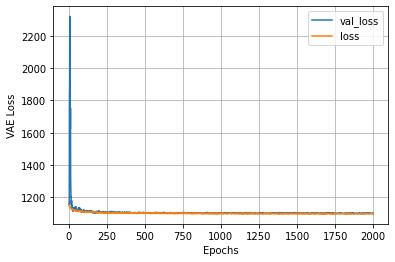

In [17]:
plt.figure()
ax = vae.history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig("hist_plot_file.png")
plt.grid()
plt.show()

In [18]:
vae = Tybalt(original_dim, latent_dim, batch_size=50, epochs=500,
                 learning_rate=0.005, kappa=0.5, epsilon_std=1.0,
                 beta=K.variable(0), loss='binary_crossentropy',
                 verbose=True)
vae._build_encoder_layer()
vae._build_decoder_layer()
vae._compile_vae()
vae._connect_layers()

vae.train_vae(pcos_train_df, pcos_test_df, separate_loss=False)

tracking <tf.Variable 'Variable_4:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_4 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_4.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/500
157/157 [==============================] - 1s 4ms/step - loss: 1156.9131 - val_loss: 1156.5286
Epoch 2/500
157/157 [==============================] - 0s 177us/step - loss: 1155.2038 - val_loss: 1155.8087
Epoch 3/500
157/157 [==============================] - 0s 165us/step - loss: 1152.9024 - val_loss: 1151.2563
Epoch 4/500
157/157 [==============================] - 0s 179us/step - loss: 1151.0285 - val_loss: 1151.6532
Epoch 5/500
157/157 [==============================] - 0s 166us/step - loss: 1149.2049 - val_loss: 1153.6174
Epoch 6/500
157/157 [==============================] - 0s 180us/step - loss: 1148.1022 - val_loss: 1151.6736
Epoch 7/500
157/157 [==============================] - 0s 197us/step - loss: 1146.1771 - val_loss: 1156.8120
Epoch 8/500
157/157 [==============================] - 0s 193us/step - loss: 1144.5959 - val_loss: 1162.2717
Epoch 9/500
157/157 [==============================] - 0s 182us/step - loss: 1142.529

<Figure size 432x288 with 0 Axes>

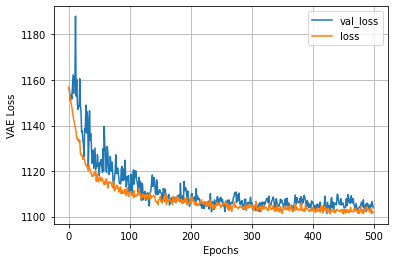

In [19]:
plt.figure()
ax = vae.history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig("hist_plot_file.png")
plt.grid()
plt.show()